In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time

# Load the datasets
files = ['clean.csv', 'mitm.csv', 'modbusQuery2Flooding.csv', 'modbusQueryFlooding.csv', 'pingFloodDDos.csv', 'tcpSYNFlood.csv']
data = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)




relevant_features = ['Length',
                    'Protocol',
                    'SrcIP',
                    'DstIP',
                    'SrcPort',
                    'DstPort',
                    'SYNFlag',
                    'ACKFlag',
                    'TimeDelta',
                    'AttackName']



data = data[relevant_features]


In [3]:
# Check the first few rows of the data to ensure it's loaded correctly
print(data.head())

# Check the columns in the loaded data
print("Columns in loaded data:", data.columns)

# Verify the unique values in 'AttackName'
print("Unique values in 'AttackName' before mapping:", data['AttackName'].unique())

   Length    Protocol              SrcIP                           DstIP  \
0      60         TCP      172.27.224.70                  172.27.224.250   
1      64         STP  HewlettP_8e:40:b3  Spanning-tree-(for-bridges)_00   
2      66  Modbus/TCP      172.27.224.70                  172.27.224.250   
3      85  Modbus/TCP     172.27.224.250                   172.27.224.70   
4      60         TCP      172.27.224.70                  172.27.224.250   

   SrcPort  DstPort  SYNFlag ACKFlag  TimeDelta AttackName  
0  49499.0    502.0  Not set     Set   0.000000      Clean  
1     -1.0     -1.0    False   False   0.020940      Clean  
2  49499.0    502.0  Not set     Set   0.073369      Clean  
3    502.0  49499.0  Not set     Set   0.003118      Clean  
4  49499.0    502.0  Not set     Set   0.214545      Clean  
Columns in loaded data: Index(['Length', 'Protocol', 'SrcIP', 'DstIP', 'SrcPort', 'DstPort', 'SYNFlag',
       'ACKFlag', 'TimeDelta', 'AttackName'],
      dtype='object')
Uniqu

In [4]:
# Load and combine datasets (assuming this part is done above)
print("Unique values in 'AttackName' before mapping:", data['AttackName'].unique())

# Ensure the mapping dictionary keys exactly match the unique values in 'AttackName'
attack_name_mapping = {
    'clean': 1,  
    'mitm': 2,
    'modbusQuery2Flooding': 3,
    'modbusQueryFlooding': 4,
    'pingFloodDDos': 5,
    'tcpSYNFlood': 6
}

# Apply the mapping
data['AttackName'] = data['AttackName'].map(attack_name_mapping)

# Check the results of the mapping
print("Unique values in 'AttackName' after mapping:", data['AttackName'].unique())
print("Non-null values in 'AttackName' after mapping:", data['AttackName'].notnull().sum())

# If after mapping, 'AttackName' has no valid data, there's a mismatch in the mapping keys
if data['AttackName'].notnull().sum() == 0:
    print("Mapping has failed, check the mapping dictionary and the original data values.")
    # Consider revising the attack_name_mapping dictionary or the original 'AttackName' data
else:
    # Proceed with dropping NaN values, encoding, imputation, and model training
    data.dropna(subset=['AttackName'], inplace=True)
    print("Data shape after dropping rows with missing 'AttackName':", data.shape)

# Only drop rows if 'AttackName' has valid data after mapping
if data['AttackName'].isnull().any():
    data.dropna(subset=['AttackName'], inplace=True)

# Ensure there is still data left after dropping NaN values
if data.empty:
    raise ValueError("No data left in DataFrame after dropping rows with missing 'AttackName'.")

# Check for non-null values before dropping rows
print("Non-null values in 'AttackName':", data['AttackName'].notnull().sum())

# Drop rows with missing 'AttackName'
data.dropna(subset=['AttackName'], inplace=True)

# Check the size of the DataFrame after dropping rows
print("Data shape after dropping rows with missing 'AttackName':", data.shape)

# Verify that we still have data to work with
if data.empty:
    raise ValueError("No data left in DataFrame after dropping rows with missing 'AttackName'.")

# Encode categorical features
categorical_features = ['Protocol', 'SrcIP', 'DstIP', 'SYNFlag', 'ACKFlag']
label_encoder = LabelEncoder()
for col in categorical_features:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# Impute missing values for the rest of the dataset
imputer = SimpleImputer(strategy='most_frequent')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Convert all columns to numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Split the dataset into features (X) and target (y)
X = data.drop(['AttackName'], axis=1)  
y = data['AttackName'].astype(int)



Unique values in 'AttackName' before mapping: ['Clean' 'mitm' 'modbusQuery2Flooding' 'modbusQueryFlooding'
 'pingFloodDDoS' 'tcpSYNFloodDDoS']
Unique values in 'AttackName' after mapping: [nan  2.  3.  4.]
Non-null values in 'AttackName' after mapping: 4475012
Data shape after dropping rows with missing 'AttackName': (4475012, 10)
Non-null values in 'AttackName': 4475012
Data shape after dropping rows with missing 'AttackName': (4475012, 10)


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    
    print(f"{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Training Time: {train_time:.4f} seconds\n")

Decision Tree:
Accuracy: 0.7077
Precision: 0.7102
Recall: 0.7153
Training Time: 13.5404 seconds

Random Forest:
Accuracy: 0.7201
Precision: 0.7227
Recall: 0.7207
Training Time: 711.1789 seconds

Gradient Boosting:
Accuracy: 0.7274
Precision: 0.7433
Recall: 0.7073
Training Time: 964.0151 seconds



: 

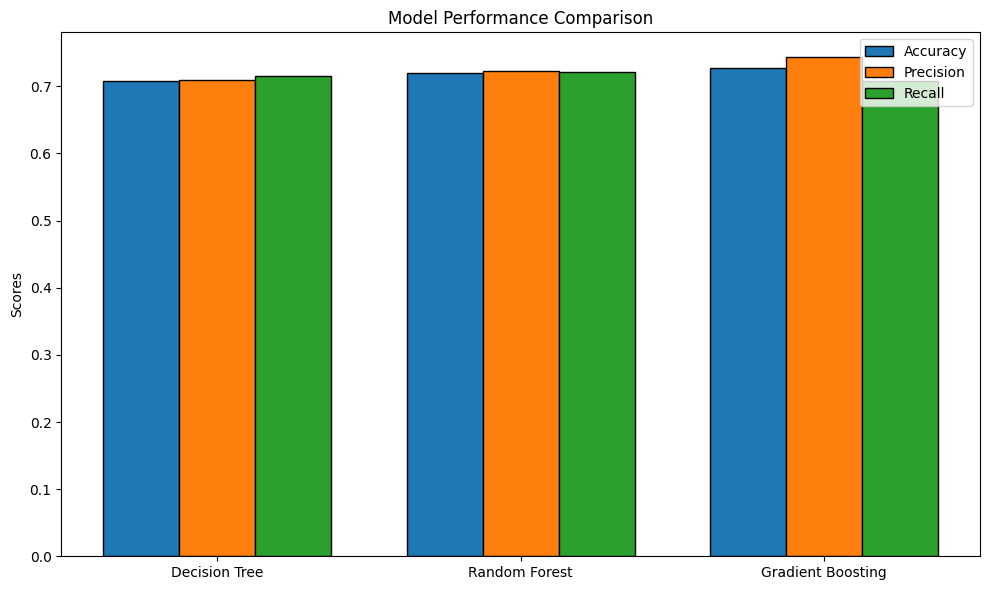

In [1]:
import matplotlib.pyplot as plt

# Model names and their performances
models = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
accuracies = [0.7077, 0.7201, 0.7274]
precisions = [0.7102, 0.7227, 0.7433]
recalls = [0.7153, 0.7207, 0.7073]

# Creating the plots
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.25
x = range(len(models))

# Plotting each metric
ax.bar(x, accuracies, width, label='Accuracy', edgecolor='black')
ax.bar([p + width for p in x], precisions, width, label='Precision', edgecolor='black')
ax.bar([p + width*2 for p in x], recalls, width, label='Recall', edgecolor='black')

# Adding labels and title
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks([p + width for p in x])
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
